# 1. Importing Packages

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter


# 2. Loading Data

In [145]:
project_data = pd.read_csv('D:\\train_data.csv',nrows = 10000)
resource_data = pd.read_csv('D:\\resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('='*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (10000, 17)
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in resources data", resource_data.shape)
print(resource_data.columns.values)

Number of data points in resources data (1541272, 4)
['id' 'description' 'quantity' 'price']


In [5]:
resource_data.head()

id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95

In [6]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  
0                                             0                    0  
1                                             7                    1

In [7]:
# we get the cost of the project using resource.csv file
resource_data.head(2)


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

In [8]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

id   price  quantity
0  p000001  459.56         7
1  p000002  515.89        21

In [9]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [10]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity  
0        23  
1         1

In [11]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].replace(np.NaN,'Mrs.')

# 3. Text Preprocessing

# 3.1. Concatenating all essay text

In [12]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

# 3.2. Preprocessing Essay text

In [13]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[9999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
sent = decontracted(project_data['essay'].values[9999])
print(sent)
print("="*50) 

\"Creative Greatness\" is this school year is mantra to inspire my students to reach for the stars. I am excited about ushering in an enthusiasm and passion for growth in the visual arts department and inspiring students to consider and apply the purpose of art outside of the classroom. \r\n\r\nMy art students and art club members are not just \"taking\" art class, but are using their creativity to engage in school-wide beautification projects and community initiatives. Help us to explore a greater variety of art media and technology in my Art 1  classes to ignite student is interest in furthering their studies in art. Our large student body limits funding to the arts, so charitable donations are crucial to our growth into Advanced Placement and College and Career Readiness programs in the arts.Our class will create personalized and unique interactive notebooks to encourage the development of independent learners and writers. Interactive notebooks are not just used for class notes, but

In [16]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

 Creative Greatness  is this school year is mantra to inspire my students to reach for the stars. I am excited about ushering in an enthusiasm and passion for growth in the visual arts department and inspiring students to consider and apply the purpose of art outside of the classroom.     My art students and art club members are not just  taking  art class, but are using their creativity to engage in school-wide beautification projects and community initiatives. Help us to explore a greater variety of art media and technology in my Art 1  classes to ignite student is interest in furthering their studies in art. Our large student body limits funding to the arts, so charitable donations are crucial to our growth into Advanced Placement and College and Career Readiness programs in the arts.Our class will create personalized and unique interactive notebooks to encourage the development of independent learners and writers. Interactive notebooks are not just used for class notes, but also fo

In [17]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

 Creative Greatness is this school year is mantra to inspire my students to reach for the stars I am excited about ushering in an enthusiasm and passion for growth in the visual arts department and inspiring students to consider and apply the purpose of art outside of the classroom My art students and art club members are not just taking art class but are using their creativity to engage in school wide beautification projects and community initiatives Help us to explore a greater variety of art media and technology in my Art 1 classes to ignite student is interest in furthering their studies in art Our large student body limits funding to the arts so charitable donations are crucial to our growth into Advanced Placement and College and Career Readiness programs in the arts Our class will create personalized and unique interactive notebooks to encourage the development of independent learners and writers Interactive notebooks are not just used for class notes but also for daily learning

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [19]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = sent.lower()
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.strip())

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1092.64it/s]


In [20]:
# after preprocesing
preprocessed_essays[9999]

'creative greatness school year mantra inspire students reach stars excited ushering enthusiasm passion growth visual arts department inspiring students consider apply purpose art outside classroom art students art club members not taking art class using creativity engage school wide beautification projects community initiatives help us explore greater variety art media technology art 1 classes ignite student interest furthering studies art large student body limits funding arts charitable donations crucial growth advanced placement college career readiness programs arts class create personalized unique interactive notebooks encourage development independent learners writers interactive notebooks not used class notes also daily learning activities require students process information presented class organize content manner reinforce learning interactive notebooks cross curricular tool supports literacy content areas art class notebooks used not affordable sketchbook option also things 

In [21]:
project_data['preprocessed_essays'] = preprocessed_essays 
project_data.drop(['essay'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  
0        23  students english learners working english seco...  
1         1  students arrive school eager learn polite gene...

# 3.3. Preprocessing Title text

In [22]:
# printing some random essays.
print(project_data['project_title'].values[0])
print("="*50)
print(project_data['project_title'].values[150])
print("="*50)
print(project_data['project_title'].values[1000])
print("="*50)
print(project_data['project_title'].values[5000])
print("="*50)
print(project_data['project_title'].values[9999])
print("="*50)

Educational Support for English Learners at Home
More Movement with Hokki Stools
Sailing Into a Super 4th Grade Year
Bouncing Our Wiggles and Worries Away!
Note Your Ordinary Notebook!


In [23]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [24]:
title = decontracted(project_data['project_title'].values[9999])
print(title)
print("="*50)

Note Your Ordinary Notebook!


In [25]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
title = title.replace('\\r', ' ')
title = title.replace('\\"', ' ')
title = title.replace('\\n', ' ')
print(title)

Note Your Ordinary Notebook!


In [26]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
title = re.sub('[^A-Za-z0-9]+', ' ', title)
print(title)

Note Your Ordinary Notebook 


In [27]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [28]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for t in tqdm(project_data['project_title'].values):
    title = decontracted(t)
    title = title.replace('\\r', ' ')
    title = title.replace('\\"', ' ')
    title = re.sub('[^A-Za-z0-9]+', ' ', title)
    # https://gist.github.com/sebleier/554280
    title = title.lower()
    title = ' '.join(e for e in title.split() if e not in stopwords)
    preprocessed_titles.append(title.strip())

100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 21056.01it/s]


In [29]:
# after preprocesing
preprocessed_titles[9999]

'note ordinary notebook'

In [30]:
project_data['preprocessed_titles'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles  
0  educational support english learners home  
1           wanted projector hungry learners

In [31]:
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

          project_subject_categories     project_subject_subcategories  \
0                Literacy & Language                     ESL, Literacy   
1  History & Civics, Health & Sports  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles  
0  educational support english learners home  
1           wanted projector hungry learners

# 4. Preprocessing of Categorical data

# 4.1. Preprocessing project_grade_category

In [32]:
project_grade_clean_category = []

for i in range(len(project_data)):
    a = project_data["project_grade_category"][i].replace(" ", "_").replace("-", "_")
    project_grade_clean_category.append(a)

In [33]:
project_grade_clean_category[0:5]

['Grades_PreK_2', 'Grades_6_8', 'Grades_6_8', 'Grades_PreK_2', 'Grades_PreK_2']

In [34]:
project_data['project_grade_clean_category'] = project_grade_clean_category 
project_data.drop(['project_grade_category'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime         project_subject_categories  \
0           IN        2016-12-05 13:43:57                Literacy & Language   
1           FL        2016-10-25 09:22:10  History & Civics, Health & Sports   

      project_subject_subcategories  \
0                     ESL, Literacy   
1  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles project_grade_clean_category  
0  educational support english learners home                Grades_PreK_2  
1           wanted projector hungry learners                   Grades_6_8

# 4.2. Preprocessing project_subject_categories

In [35]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [36]:
cat_list[0:5]

['Literacy_Language',
 'History_Civics Health_Sports',
 'Health_Sports',
 'Literacy_Language Math_Science',
 'Math_Science']

In [37]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime     project_subject_subcategories  \
0           IN        2016-12-05 13:43:57                     ESL, Literacy   
1           FL        2016-10-25 09:22:10  Civics & Government, Team Sports   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles project_grade_clean_category  \
0  educational support english learners home                Grades_PreK_2   
1           wanted projector hungry learners                   Grades_6_8   

               clean_categories  
0             Literacy_Language  
1  History_Civics Health_Sports

# 4.3. Preprocessing project_subject_subcategories


In [38]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [39]:
sub_cat_list[0:5]

['ESL Literacy',
 'Civics_Government TeamSports',
 'Health_Wellness TeamSports',
 'Literacy Mathematics',
 'Mathematics']

In [40]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime  \
0           IN        2016-12-05 13:43:57   
1           FL        2016-10-25 09:22:10   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   

   teacher_number_of_previously_posted_projects  project_is_approved  price  \
0                                             0                    0  154.6   
1                                             7                    1  299.0   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   

                         preprocessed_titles project_grade_clean_category  \
0  educational support english learners home                Grades_PreK_2   
1           wanted projector hungry learners                   Grades_6_8   

               clean_categories           clean_subcategories  
0             Literacy_Language                  ESL Literacy  
1  History_Civics Health_Sports  Civics_Government TeamSports

In [41]:
project_data.head()

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   
2       21895  p182444  3465aaf82da834c0582ebd0ef8040ca0            Ms.   
3          45  p246581  f3cb9bffbba169bef1a77b243e620b60           Mrs.   
4      172407  p104768  be1f7507a41f8479dc06f047086a39ec           Mrs.   

  school_state project_submitted_datetime  \
0           IN        2016-12-05 13:43:57   
1           FL        2016-10-25 09:22:10   
2           AZ        2016-08-31 12:03:56   
3           KY        2016-10-06 21:16:17   
4           TX        2016-07-11 01:10:09   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   
2  \r\n\"True champions aren't always the ones th...   
3  I work at a unique school filled with both ESL...   
4  Our second grade classroom next year will be m...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   
2  The students on the campus come to school know...             NaN   
3  My students live in high poverty conditions wi...             NaN   
4  For many students, math is a subject that does...             NaN   

  project_essay_4                           project_resource_summary  \
0             NaN  My students need opportunities to practice beg...   
1             NaN  My students need a projector to help with view...   
2             NaN  My students need shine guards, athletic socks,...   
3             NaN  My students need to engage in Reading and Math...   
4             NaN  My students need hands on practice in mathemat...   

   teacher_number_of_previously_posted_projects  project_is_approved   price  \
0                                             0                    0  154.60   
1                                             7                    1  299.00   
2                                             1                    0  516.85   
3                                             4                    1  232.90   
4                                             1                    1   67.98   

   quantity                                preprocessed_essays  \
0        23  students english learners working english seco...   
1         1  students arrive school eager learn polite gene...   
2        22  true champions not always ones win guts mia ha...   
3         4  work unique school filled esl english second l...   
4         4  second grade classroom next year made around 2...   

                               preprocessed_titles  \
0        educational support english learners home   
1                 wanted projector hungry learners   
2  soccer equipment awesome middle school students   
3                           techie kindergarteners   
4                           interactive math tools   

  project_grade_clean_category                clean_categories  \
0                Grades_PreK_2               Literacy_Language   
1                   Grades_6_8    History_Civics Health_Sports   
2                   Grades_6_8                   Health_Sports   
3                Grades_PreK_2  Literacy_Language Math_Science   
4                Grades_PreK_2                    Math_Science   

            clean_subcategories  
0                  ESL Literacy  
1  Civics_Government TeamSports  
2    Health_Wellness TeamSports  
3          Literacy Mathematics  
4                   Mathematics

# 5. Counting number of words in the combine essays

In [42]:
essay_count = []
for word in project_data['preprocessed_essays']:
    a = len(word.split())
    b = str(a)
    essay_count.append(b)

In [43]:
essay_count[9999]

'236'

In [44]:
project_data['number_of_words_in_essays'] = essay_count 
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime  \
0           IN        2016-12-05 13:43:57   
1           FL        2016-10-25 09:22:10   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4  ... teacher_number_of_previously_posted_projects  \
0             NaN  ...                                            0   
1             NaN  ...                                            7   

   project_is_approved  price  quantity  \
0                    0  154.6        23   
1                    1  299.0         1   

                                 preprocessed_essays  \
0  students english learners working english seco...   
1  students arrive school eager learn polite gene...   

                         preprocessed_titles project_grade_clean_category  \
0  educational support english learners home                Grades_PreK_2   
1           wanted projector hungry learners                   Grades_6_8   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

  number_of_words_in_essays  
0                       149  
1                        99  

[2 rows x 21 columns]

# 6. Counting number of words in the title

In [45]:
title_count = []
for word in project_data['preprocessed_titles']:
    a = len(word.split())
    b = str(a)
    title_count.append(b)

In [46]:
title_count[9999]

'3'

In [47]:
project_data['number_of_words_in_the_title'] = title_count
project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime  \
0           IN        2016-12-05 13:43:57   
1           FL        2016-10-25 09:22:10   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2 project_essay_3  \
0  \"The limits of your language are the limits o...             NaN   
1  The projector we need for our school is very c...             NaN   

  project_essay_4  ... project_is_approved  price  quantity  \
0             NaN  ...                   0  154.6        23   
1             NaN  ...                   1  299.0         1   

                                 preprocessed_essays  \
0  students english learners working english seco...   
1  students arrive school eager learn polite gene...   

                         preprocessed_titles project_grade_clean_category  \
0  educational support english learners home                Grades_PreK_2   
1           wanted projector hungry learners                   Grades_6_8   

               clean_categories           clean_subcategories  \
0             Literacy_Language                  ESL Literacy   
1  History_Civics Health_Sports  Civics_Government TeamSports   

  number_of_words_in_essays number_of_words_in_the_title  
0                       149                            5  
1                        99                            4  

[2 rows x 22 columns]

# 7. Splitting data

In [48]:
Xproject_data= project_data
print(Xproject_data.shape)
Yproject_data = Xproject_data['project_is_approved']
print(Yproject_data.shape)
Xproject_data.drop(['project_is_approved'], axis=1, inplace=True)
print(Xproject_data.shape)

(10000, 22)
(10000,)
(10000, 21)


# 8. Encoding Categorigal data

# 8.1. One Hot Encoding of clean_categories

In [49]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(lowercase=False, binary=True)
vectorizer1.fit(Xproject_data['clean_categories'].values)
print(vectorizer1.get_feature_names())


categories_one_hot_encode = vectorizer1.transform(Xproject_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot_encode.shape)

['AppliedLearning', 'Care_Hunger', 'Health_Sports', 'History_Civics', 'Literacy_Language', 'Math_Science', 'Music_Arts', 'SpecialNeeds', 'Warmth']
Shape of matrix after one hot encodig  (10000, 9)


# 8.2. One Hot Encoding of clean_subcategories

In [50]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer2 = CountVectorizer(lowercase=False, binary=True)
vectorizer2.fit(Xproject_data['clean_subcategories'].values)
print(vectorizer2.get_feature_names())


sub_categories_one_hot_encode = vectorizer2.transform(Xproject_data['clean_subcategories'].values)


print("Shape of matrix after one hot encoding ",sub_categories_one_hot_encode.shape)


['AppliedSciences', 'Care_Hunger', 'CharacterEducation', 'Civics_Government', 'College_CareerPrep', 'CommunityService', 'ESL', 'EarlyDevelopment', 'Economics', 'EnvironmentalScience', 'Extracurricular', 'FinancialLiteracy', 'ForeignLanguages', 'Gym_Fitness', 'Health_LifeScience', 'Health_Wellness', 'History_Geography', 'Literacy', 'Literature_Writing', 'Mathematics', 'Music', 'NutritionEducation', 'Other', 'ParentInvolvement', 'PerformingArts', 'SocialSciences', 'SpecialNeeds', 'TeamSports', 'VisualArts', 'Warmth']
Shape of matrix after one hot encoding  (10000, 30)


# 8.3. One Hot Encoding of school_state

In [51]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer3 = CountVectorizer(lowercase=False, binary=True)
vectorizer3.fit(Xproject_data['school_state'].values)
print(vectorizer3.get_feature_names())


school_state_one_hot_encode = vectorizer3.transform(Xproject_data['school_state'].values)


print("Shape of matrix after one hot encoding ",school_state_one_hot_encode.shape)


['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of matrix after one hot encoding  (10000, 51)


# 8.4. One Hot Encoding of teacher_prefix

In [52]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer4 = CountVectorizer(lowercase=False, binary=True)
vectorizer4.fit(Xproject_data['teacher_prefix'].values)
print(vectorizer4.get_feature_names())

teacher_prefix_one_hot_encode = vectorizer4.transform(Xproject_data['teacher_prefix'].values)


print("Shape of matrix after one hot encoding ",teacher_prefix_one_hot_encode.shape)


['Mr', 'Mrs', 'Ms', 'Teacher']
Shape of matrix after one hot encoding  (10000, 4)


# 8.5. One Hot Encoding of project_grade_clean_category

In [53]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer5 = CountVectorizer(lowercase=False, binary=True)
vectorizer5.fit(Xproject_data['project_grade_clean_category'].values)
print(vectorizer5.get_feature_names())


grade_one_hot_encode = vectorizer5.transform(Xproject_data['project_grade_clean_category'].values)

print("Shape of matrix after one hot encoding ",grade_one_hot_encode.shape)


['Grades_3_5', 'Grades_6_8', 'Grades_9_12', 'Grades_PreK_2']
Shape of matrix after one hot encoding  (10000, 4)


# 9. Encoding of Text Data

# 9.1. BOW Encoding on preprocessed_essays

In [54]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer6 = CountVectorizer(min_df=10)
text_bow = vectorizer6.fit_transform(Xproject_data['preprocessed_essays'].values)
print("Shape of matrix after one hot encodig ",text_bow.shape)


Shape of matrix after one hot encodig  (10000, 6127)


# 9.2. BOW Encoding on preprocessed_titles

In [55]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer7 = CountVectorizer(min_df=10)
title_bow = vectorizer7.fit_transform(Xproject_data['preprocessed_titles'].values)
print("Shape of matrix after one hot encodig ",title_bow.shape)


Shape of matrix after one hot encodig  (10000, 607)


# 10. Encoding of Numerical Data

# 10.1. Encoding of price data

In [58]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler


scalar = MinMaxScaler()
 
price_standardized = scalar.fit_transform(Xproject_data['price'].values.reshape(-1, 1))
print(price_standardized.shape)

(10000, 1)


In [59]:
price_standardized

array([[0.01531974],
       [0.02976326],
       [0.05155358],
       ...,
       [0.03520959],
       [0.03266397],
       [0.02109015]])

# 10.2. Encoding of quantity data

In [60]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

quantity_standardized = scalar.fit_transform(Xproject_data['quantity'].values.reshape(-1, 1))
print(quantity_standardized.shape)

(10000, 1)


In [61]:
quantity_standardized

array([[0.03793103],
       [0.        ],
       [0.0362069 ],
       ...,
       [0.02758621],
       [0.00172414],
       [0.06034483]])

# 10.3. Encoding of teacher_number_of_previously_posted_projects data

In [62]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

# Now standardize the data with above maen and variance.
teacher_number_of_previously_posted_projects_standardized = scalar.fit_transform(Xproject_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
print(teacher_number_of_previously_posted_projects_standardized.shape)

(10000, 1)


In [63]:
teacher_number_of_previously_posted_projects_standardized

array([[0.        ],
       [0.01851852],
       [0.0026455 ],
       ...,
       [0.01058201],
       [0.01587302],
       [0.01322751]])

# 10.4. Encoding of number_of_words_in_essays data

In [64]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

number_of_words_in_essays_standardized = scalar.fit_transform(Xproject_data['number_of_words_in_essays'].values.reshape(-1, 1))
print(number_of_words_in_essays_standardized.shape)

(10000, 1)


In [65]:
number_of_words_in_essays_standardized

array([[0.33617021],
       [0.12340426],
       [0.50212766],
       ...,
       [0.37021277],
       [0.17446809],
       [0.70638298]])

# 10.5. Encoding of number_of_words_in_the_title data

In [66]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()

number_of_words_in_the_title_standardized = scalar.fit_transform(Xproject_data['number_of_words_in_the_title'].values.reshape(-1, 1))
print(number_of_words_in_the_title_standardized.shape)

(10000, 1)


In [67]:
number_of_words_in_the_title_standardized

array([[0.45454545],
       [0.36363636],
       [0.54545455],
       ...,
       [0.45454545],
       [0.18181818],
       [0.27272727]])

# 11. Printing Dimensions of all Preprocessed Data

In [68]:
print(categories_one_hot_encode.shape)
print(sub_categories_one_hot_encode.shape)
print(school_state_one_hot_encode.shape)
print(teacher_prefix_one_hot_encode.shape)
print(grade_one_hot_encode.shape)
print(text_bow.shape)
print(title_bow.shape)
print(price_standardized.shape)
print(quantity_standardized.shape)
print(teacher_number_of_previously_posted_projects_standardized.shape)
print(number_of_words_in_essays_standardized.shape)
print(number_of_words_in_the_title_standardized.shape)


(10000, 9)
(10000, 30)
(10000, 51)
(10000, 4)
(10000, 4)
(10000, 6127)
(10000, 607)
(10000, 6127)
(10000, 607)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)
(10000, 1)


# Set 1: categorical, numerical features + project_title(BOW) +preprocessed_eassay

In [69]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
Xset1 = hstack((categories_one_hot_encode,sub_categories_one_hot_encode,school_state_one_hot_encode,teacher_prefix_one_hot_encode,grade_one_hot_encode,price_standardized,quantity_standardized,teacher_number_of_previously_posted_projects_standardized,text_bow,title_bow)).tocsr()

print(Xset1.shape,Yproject_data.shape)


(10000, 6835) (10000,)


In [70]:
type(Xset1)

scipy.sparse.csr.csr_matrix

# 12. Selecting top 5K features

In [72]:
from sklearn.feature_selection import SelectKBest, chi2
selector1 =  SelectKBest(chi2, k=5000)
X_set1_new = selector1.fit_transform(Xset1, Yproject_data)

In [73]:
selector1.get_support(indices=True)

array([   0,    1,    3, ..., 6831, 6832, 6833], dtype=int64)

In [74]:
X_set1_new_dataframe = pd.DataFrame(Xset1.toarray())

In [75]:
X_set1_new_dataframe.shape

(10000, 6835)

In [76]:
# https://stackoverflow.com/questions/36967666/transform-scipy-sparse-csr-to-pandas
names = X_set1_new_dataframe.columns.values[selector1.get_support()]
scores = selector1.scores_[selector1.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feature_names', 'Feature_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['Feature_Scores', 'Feature_names'], ascending = [False, True])
ns_df_sorted.head()

Feature_names  Feature_Scores
2583           3583      136.413734
576             805      130.505981
3948           5401      111.390002
788            1105       65.114507
3344           4595       64.766623

In [77]:
print(ns_df_sorted.shape)

(5000, 2)


# 13. Kmeans

In [80]:
from sklearn.cluster import KMeans
def getLosses(hyperparameter, data_matrix):
    loss = []
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=-1).fit(data_matrix)
        loss.append(kmeans.inertia_)
        
    return loss

def plotGraph(hyperparameter, loss):
    plt.plot(hyperparameter, loss, label='elbow','-+')
    
    plt.title("Plot to find best K using elbow-knee method")
    plt.xlabel('number of clusters (K)')
    plt.ylabel('loss value')
    plt.legend()
    plt.grid(True)


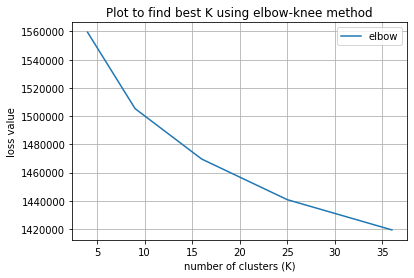

In [81]:
K = [4, 9, 16, 25, 36]
loss_value = getLosses(K, X_set1_new)
plotGraph(K, loss_value)


# 14. Fitting the kmeans with selected best K(n_clusters)

In [82]:
kmeans = KMeans(n_clusters = 16, random_state=0, n_jobs=-1).fit(X_set1_new)

In [83]:
FN = project_data['preprocessed_essays'].values

In [89]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []
cluster10 = []
cluster11 = []
cluster12 = []
cluster13 = []
cluster14 = []
cluster15 = []
cluster16 = []


for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(FN[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(FN[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(FN[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(FN[i])
    elif kmeans.labels_[i] == 4:
        cluster5.append(FN[i])
    elif kmeans.labels_[i] == 5:
        cluster6.append(FN[i])
    elif kmeans.labels_[i] == 6:
        cluster7.append(FN[i])
    elif kmeans.labels_[i] == 7:
        cluster8.append(FN[i])
    elif kmeans.labels_[i] == 8:
        cluster9.append(FN[i])
    elif kmeans.labels_[i] == 9:
        cluster10.append(FN[i])
    elif kmeans.labels_[i] == 10:
        cluster11.append(FN[i])
    elif kmeans.labels_[i] == 11:
        cluster12.append(FN[i])
    elif kmeans.labels_[i] == 12:
        cluster13.append(FN[i])
    elif kmeans.labels_[i] == 13:
        cluster14.append(FN[i])
    elif kmeans.labels_[i] == 14:
        cluster15.append(FN[i])
    
    else :
        cluster16.append(FN[i]) 
        
# Number of reviews in different clusters
print("\nNo. of essay in Cluster-1  : ",len(cluster1))
print("\nNo. of essay in Cluster-2  : ",len(cluster2))
print("\nNo. of essay in Cluster-3  : ",len(cluster3))
print("\nNo. of essay in Cluster-4  : ",len(cluster4))
print("\nNo. of essay in Cluster-5  : ",len(cluster5))
print("\nNo. of essay in Cluster-6  : ",len(cluster6))
print("\nNo. of essay in Cluster-7  : ",len(cluster7))
print("\nNo. of essay in Cluster-8  : ",len(cluster8))
print("\nNo. of essay in Cluster-9  : ",len(cluster9))
print("\nNo. of essay in Cluster-10 : ",len(cluster10))
print("\nNo. of essay in Cluster-11 : ",len(cluster11))
print("\nNo. of essay in Cluster-12 : ",len(cluster12))
print("\nNo. of essay in Cluster-13 : ",len(cluster13))
print("\nNo. of essay in Cluster-14 : ",len(cluster14))
print("\nNo. of essay in Cluster-15 : ",len(cluster15))
print("\nNo. of essay in Cluster-16 : ",len(cluster16))



No. of essay in Cluster-1  :  289

No. of essay in Cluster-2  :  677

No. of essay in Cluster-3  :  598

No. of essay in Cluster-4  :  510

No. of essay in Cluster-5  :  684

No. of essay in Cluster-6  :  279

No. of essay in Cluster-7  :  1096

No. of essay in Cluster-8  :  168

No. of essay in Cluster-9  :  883

No. of essay in Cluster-10 :  1

No. of essay in Cluster-11 :  1648

No. of essay in Cluster-12 :  257

No. of essay in Cluster-13 :  1436

No. of essay in Cluster-14 :  542

No. of essay in Cluster-15 :  380

No. of essay in Cluster-16 :  552


In [90]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

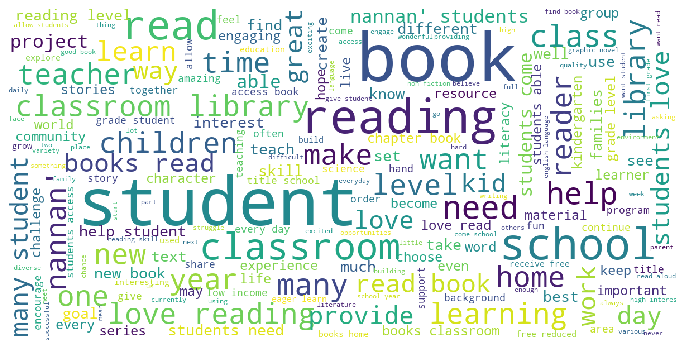

In [91]:
show_wordcloud(cluster1)

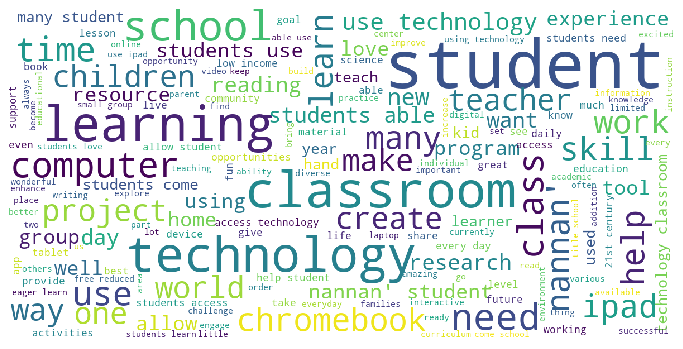

In [92]:
show_wordcloud(cluster2)

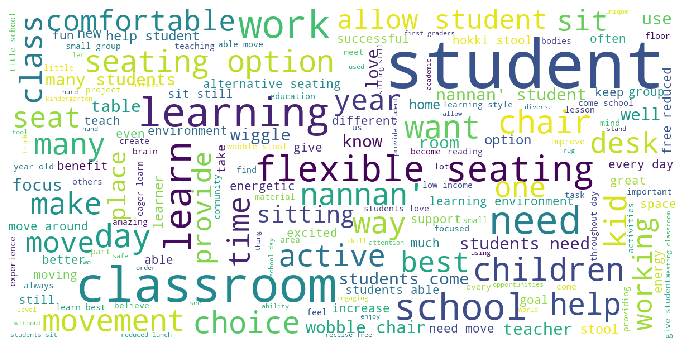

In [93]:
show_wordcloud(cluster3)

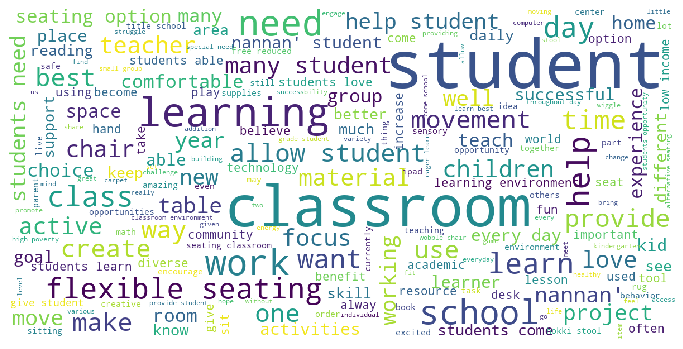

In [94]:
show_wordcloud(cluster4)

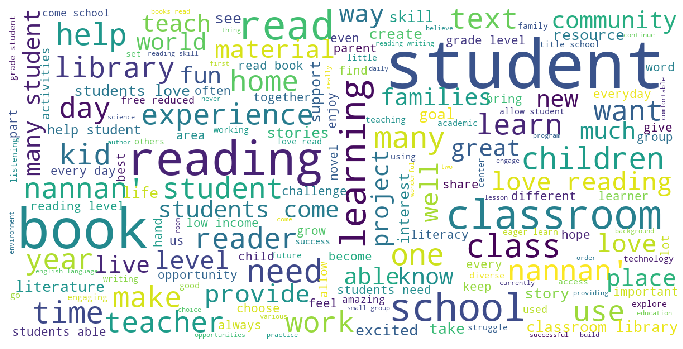

In [95]:
show_wordcloud(cluster5)

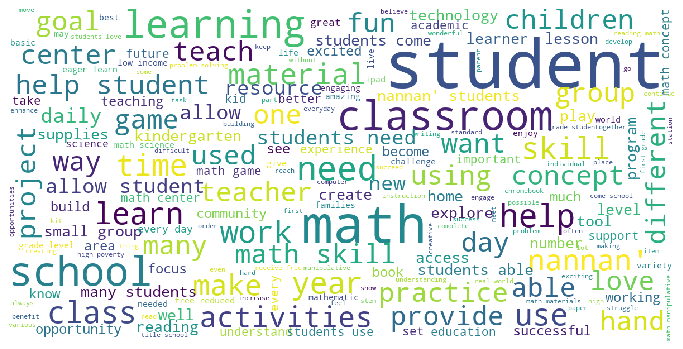

In [96]:
show_wordcloud(cluster6)

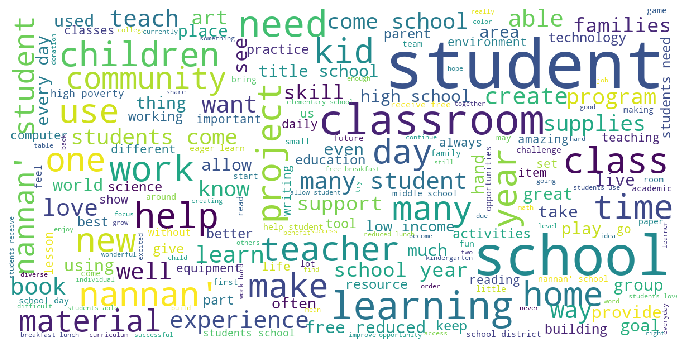

In [97]:
show_wordcloud(cluster7)

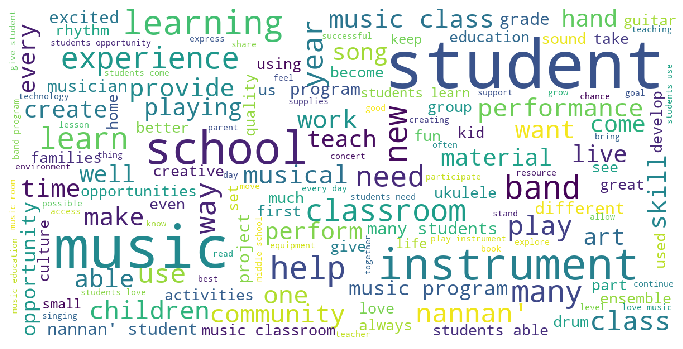

In [98]:
show_wordcloud(cluster8)

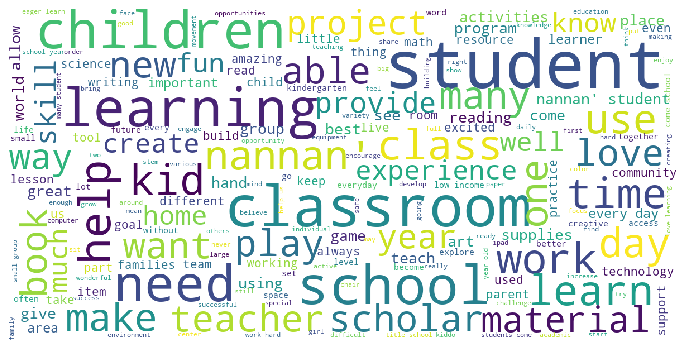

In [99]:
show_wordcloud(cluster9)

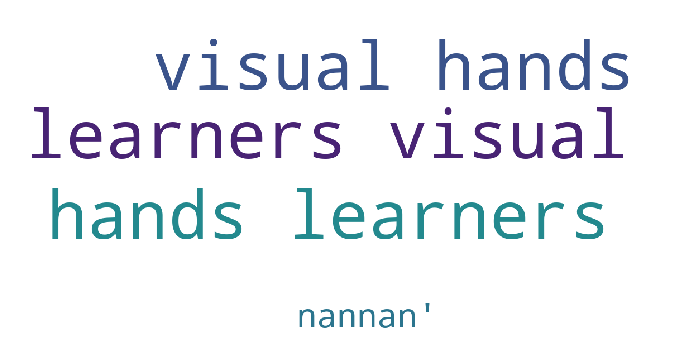

In [100]:
show_wordcloud(cluster10)

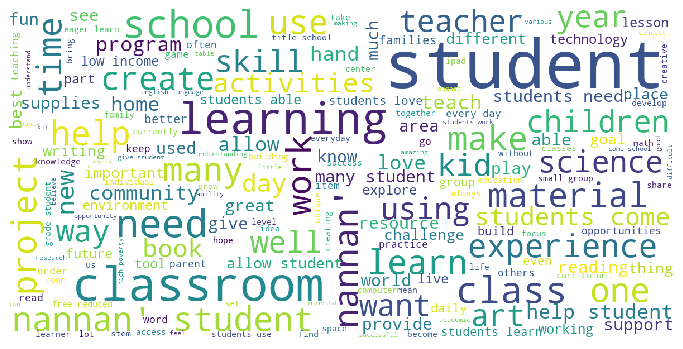

In [101]:
show_wordcloud(cluster11)

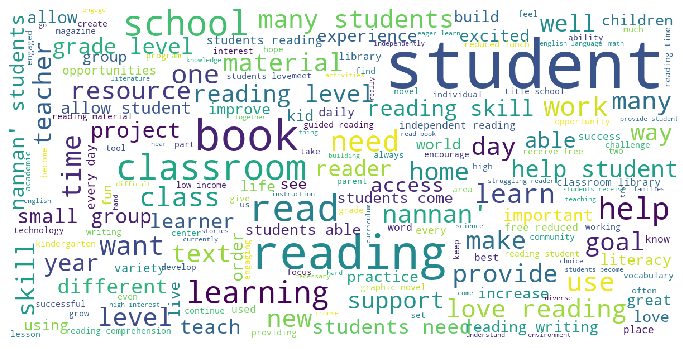

In [102]:
show_wordcloud(cluster12)

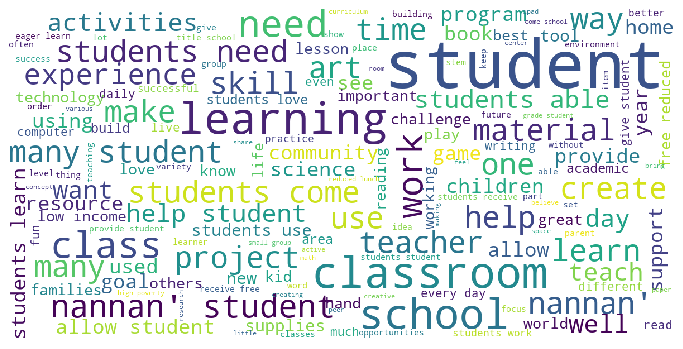

In [103]:
show_wordcloud(cluster13)

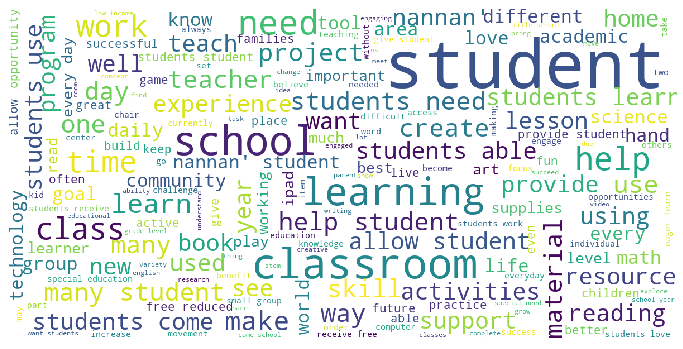

In [104]:
show_wordcloud(cluster14)

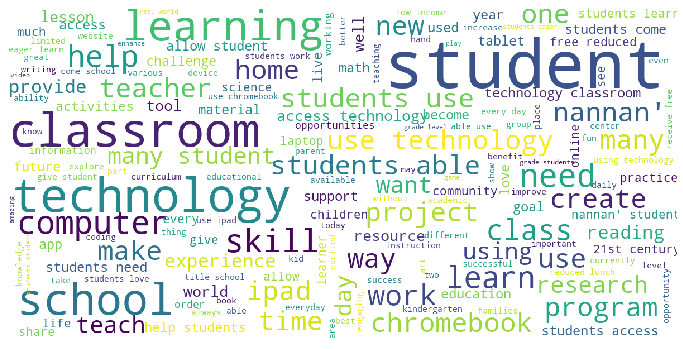

In [105]:
show_wordcloud(cluster15)

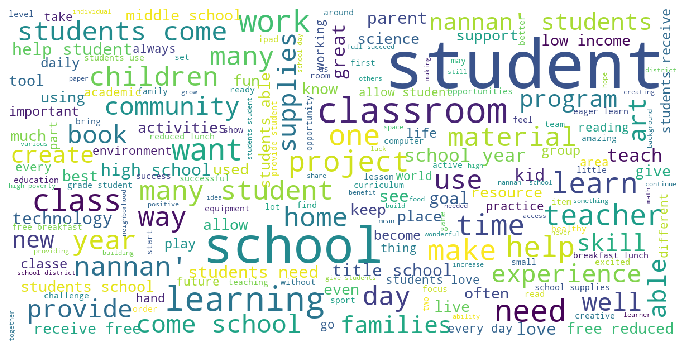

In [106]:
show_wordcloud(cluster16)

# 15. Agglomerative

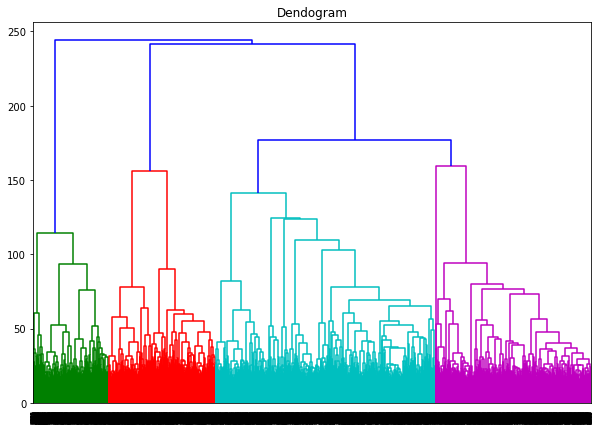

In [107]:
import scipy.cluster.hierarchy as sch

X_set1_new_dense = X_set1_new.todense()

plt.figure(figsize=(10, 7))  
plt.title("Dendogram")  
dendo = sch.hierarchy.dendrogram(sch.linkage(X_set1_new_dense, method='ward'))  

In [109]:
from sklearn.cluster import AgglomerativeClustering
Agglo = AgglomerativeClustering(n_clusters = 4).fit(X_set1_new_dense)

In [111]:
# Getting all the reviews in different clusters
Acluster1 = []
Acluster2 = []
Acluster3 = []
Acluster4 = []



for i in range(Agglo.labels_.shape[0]):
    if Agglo.labels_[i] == 0:
        Acluster1.append(FN[i])
    elif Agglo.labels_[i] == 1:
        Acluster2.append(FN[i])
    elif Agglo.labels_[i] == 2:
        Acluster3.append(FN[i])
    else :
        Acluster4.append(FN[i]) 
        
# Number of reviews in different clusters
print("\nNo. of essay in Cluster-1  : ",len(Acluster1))
print("\nNo. of essay in Cluster-2  : ",len(Acluster2))
print("\nNo. of essay in Cluster-3  : ",len(Acluster3))
print("\nNo. of essay in Cluster-4  : ",len(Acluster4))


No. of essay in Cluster-1  :  2790

No. of essay in Cluster-2  :  3935

No. of essay in Cluster-3  :  1917

No. of essay in Cluster-4  :  1358


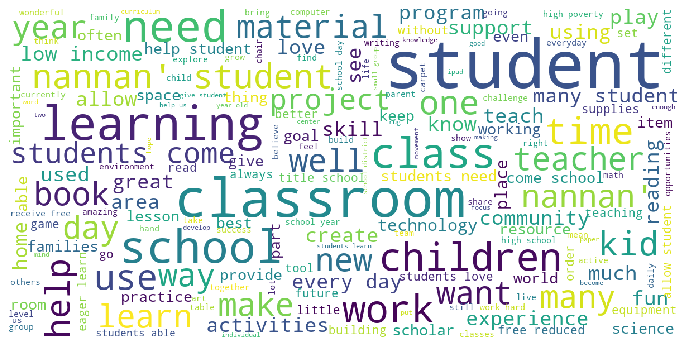

In [112]:
show_wordcloud(Acluster1)

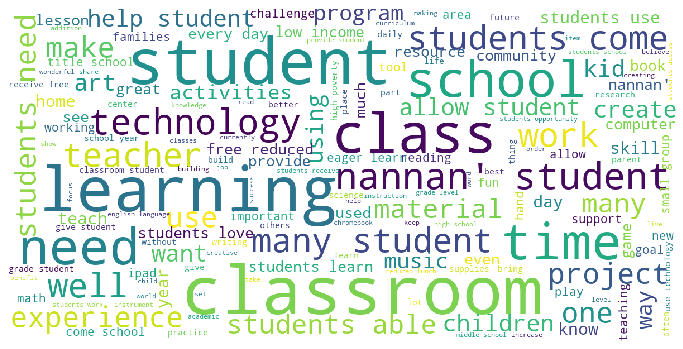

In [113]:
show_wordcloud(Acluster2)

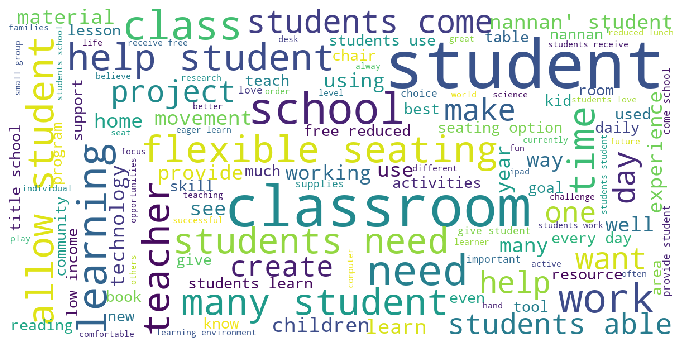

In [114]:
show_wordcloud(Acluster3)

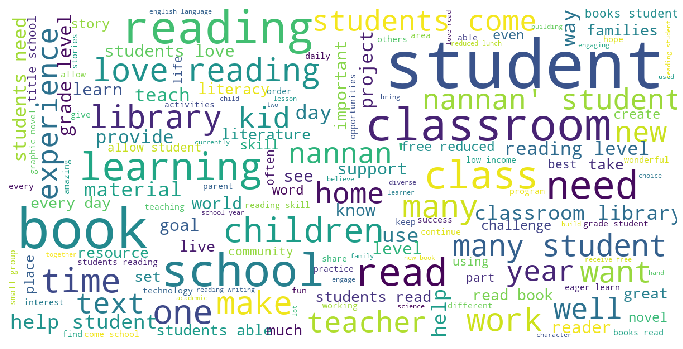

In [115]:
show_wordcloud(Acluster4)

# 16. DBSCAN 

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [14:40<00:00, 11.36it/s]


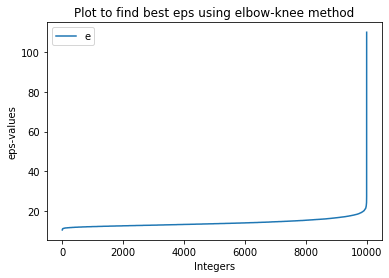

In [118]:
from sklearn.neighbors import KDTree

algo_title = 'DBSCAN Clustering'
minPts = 10                        #minPts:ln(n),n = 10000
tree = KDTree(X_set1_new_dense)

idx = 0
eps = []
for x_i in tqdm(X_set1_new_dense):
    eps.append(tree.query(X_set1_new_dense[idx], return_distance=True, k=minPts)[0][0][-1])
    idx += 1
eps.sort()

plt.plot(range(0,10000), eps[:10000])
plt.title("Plot to find best eps using elbow-knee method")
plt.xlabel('Integers')
plt.ylabel('eps-values')
plt.legend('elbow')

In [128]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps = 19, min_samples=10, metric='euclidean').fit(X_set1_new_dense)

In [129]:
a = dbscan.labels_.tolist()

In [137]:
a[0:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [144]:
a[140:160]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]

In [131]:
# Getting all the reviews in different clusters
dbcluster1 = []
dbcluster2 = []




for i in range(Agglo.labels_.shape[0]):
    if dbscan.labels_[i] == 0:
        dbcluster1.append(FN[i])
    else :
        dbcluster2.append(FN[i]) 
        
# Number of reviews in different clusters
print("\nNo. of essay in Cluster-1  : ",len(dbcluster1))
print("\nNo. of essay in Cluster-2  : ",len(dbcluster2))



No. of essay in Cluster-1  :  9879

No. of essay in Cluster-2  :  121


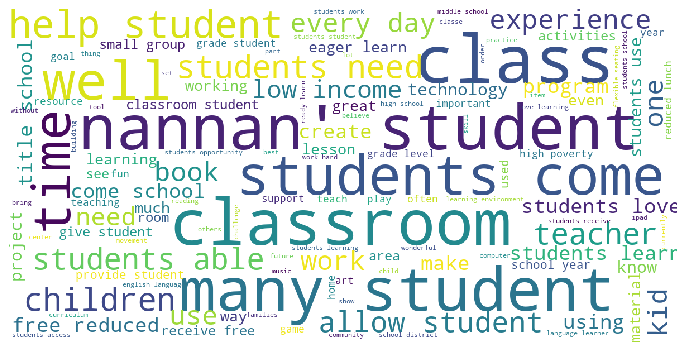

In [132]:
show_wordcloud(dbcluster1)

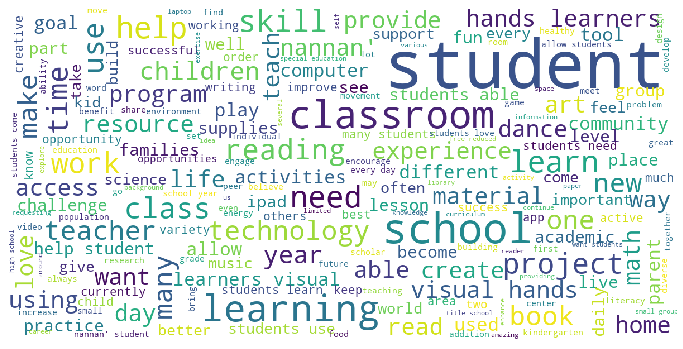

In [133]:
show_wordcloud(dbcluster2)

# 17. Observations

### 1. Here,we have taken only 10k datapoints due to computation issue prepreccessed the data and vectorized the data.
### 2. After vectorized stacked up the data using hstack and applied kmeans,Agglomerative and Dbscan algorithms on the data.
### 3. When applied kmeans got 16 clusters out of which the 10th cluster has nly one datapoint which implies or can be considered as an outier.
### 4. When applied Aglomerative got 4 clusters after visualizing dendogram and worked preety well.
### 5. When applied DBSCAN got two clusters 0 and -1,where -1 implies an outlier points.

# 18. Conclusion

In [ ]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()

x.field_names = ["Clustering Type", "Hyperameter method", "Number of Clusters"]

x.add_row(["K-means", "Elbow Method", 16])
x.add_row(["Agglomerative", "Dendograms", 4])
x.add_row(["DBSCAN", "Elbow Method",2])

